## **Predicting Disease Spread: Prediction comparison**

### **Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
prophet_mean = pd.read_csv('../data/predictions/prophet_mean.csv')
arima = pd.read_csv('../data/predictions/arima.csv')
as_mean = pd.read_csv('../data/predictions/estimated_as_mean.csv')
prev_iter_rf = pd.read_csv('../data/predictions/prev_as_iterative_rf_sep_cities.csv')
ensemble_prophet_arima = pd.read_csv('../data/predictions/ensemble/prophet_arima.csv')
maximum_df = pd.read_csv('../data/predictions/ensemble/maximum.csv')
max_for_sj_mean_for_iq = pd.read_csv('../data/predictions/ensemble/mean_for_iq_max_for_sj.csv')
proph_arima_mean_roll_3 = pd.read_csv('../data/predictions/ensemble/proph_arima_mean_roll_3.csv')

In [3]:
def plot_predictions(*predictions):
    """
    Plots predictions for San Juan and Iquitos on separate plots with all predictions.

    Parameters:
    predictions: List of tuples where each tuple contains:
        - prediction (pd.DataFrame): The prediction DataFrame.
        - mae (float): The Mean Absolute Error.
        - title (str): The title for the prediction.
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 16), sharex=True)

    for prediction, mae, title in predictions:
        prediction['date'] = pd.to_datetime(prediction['year'].astype(str) + '-W' + prediction['weekofyear'].astype(str) + '-1', format='%Y-W%U-%w')
        sj_prediction = prediction[prediction['city'] == 'sj']
        iq_prediction = prediction[prediction['city'] == 'iq']

        sns.lineplot(data=sj_prediction, x="date", y='total_cases', ax=axes[0], label=f"{title} MAE: {mae}")
        sns.lineplot(data=iq_prediction, x="date", y='total_cases', ax=axes[1], label=f"{title} MAE: {mae}")

    axes[0].set_title('Predictions for San Juan')
    axes[0].legend()
    axes[1].set_title('Predictions for Iquitos')
    axes[1].legend()

    plt.tight_layout()


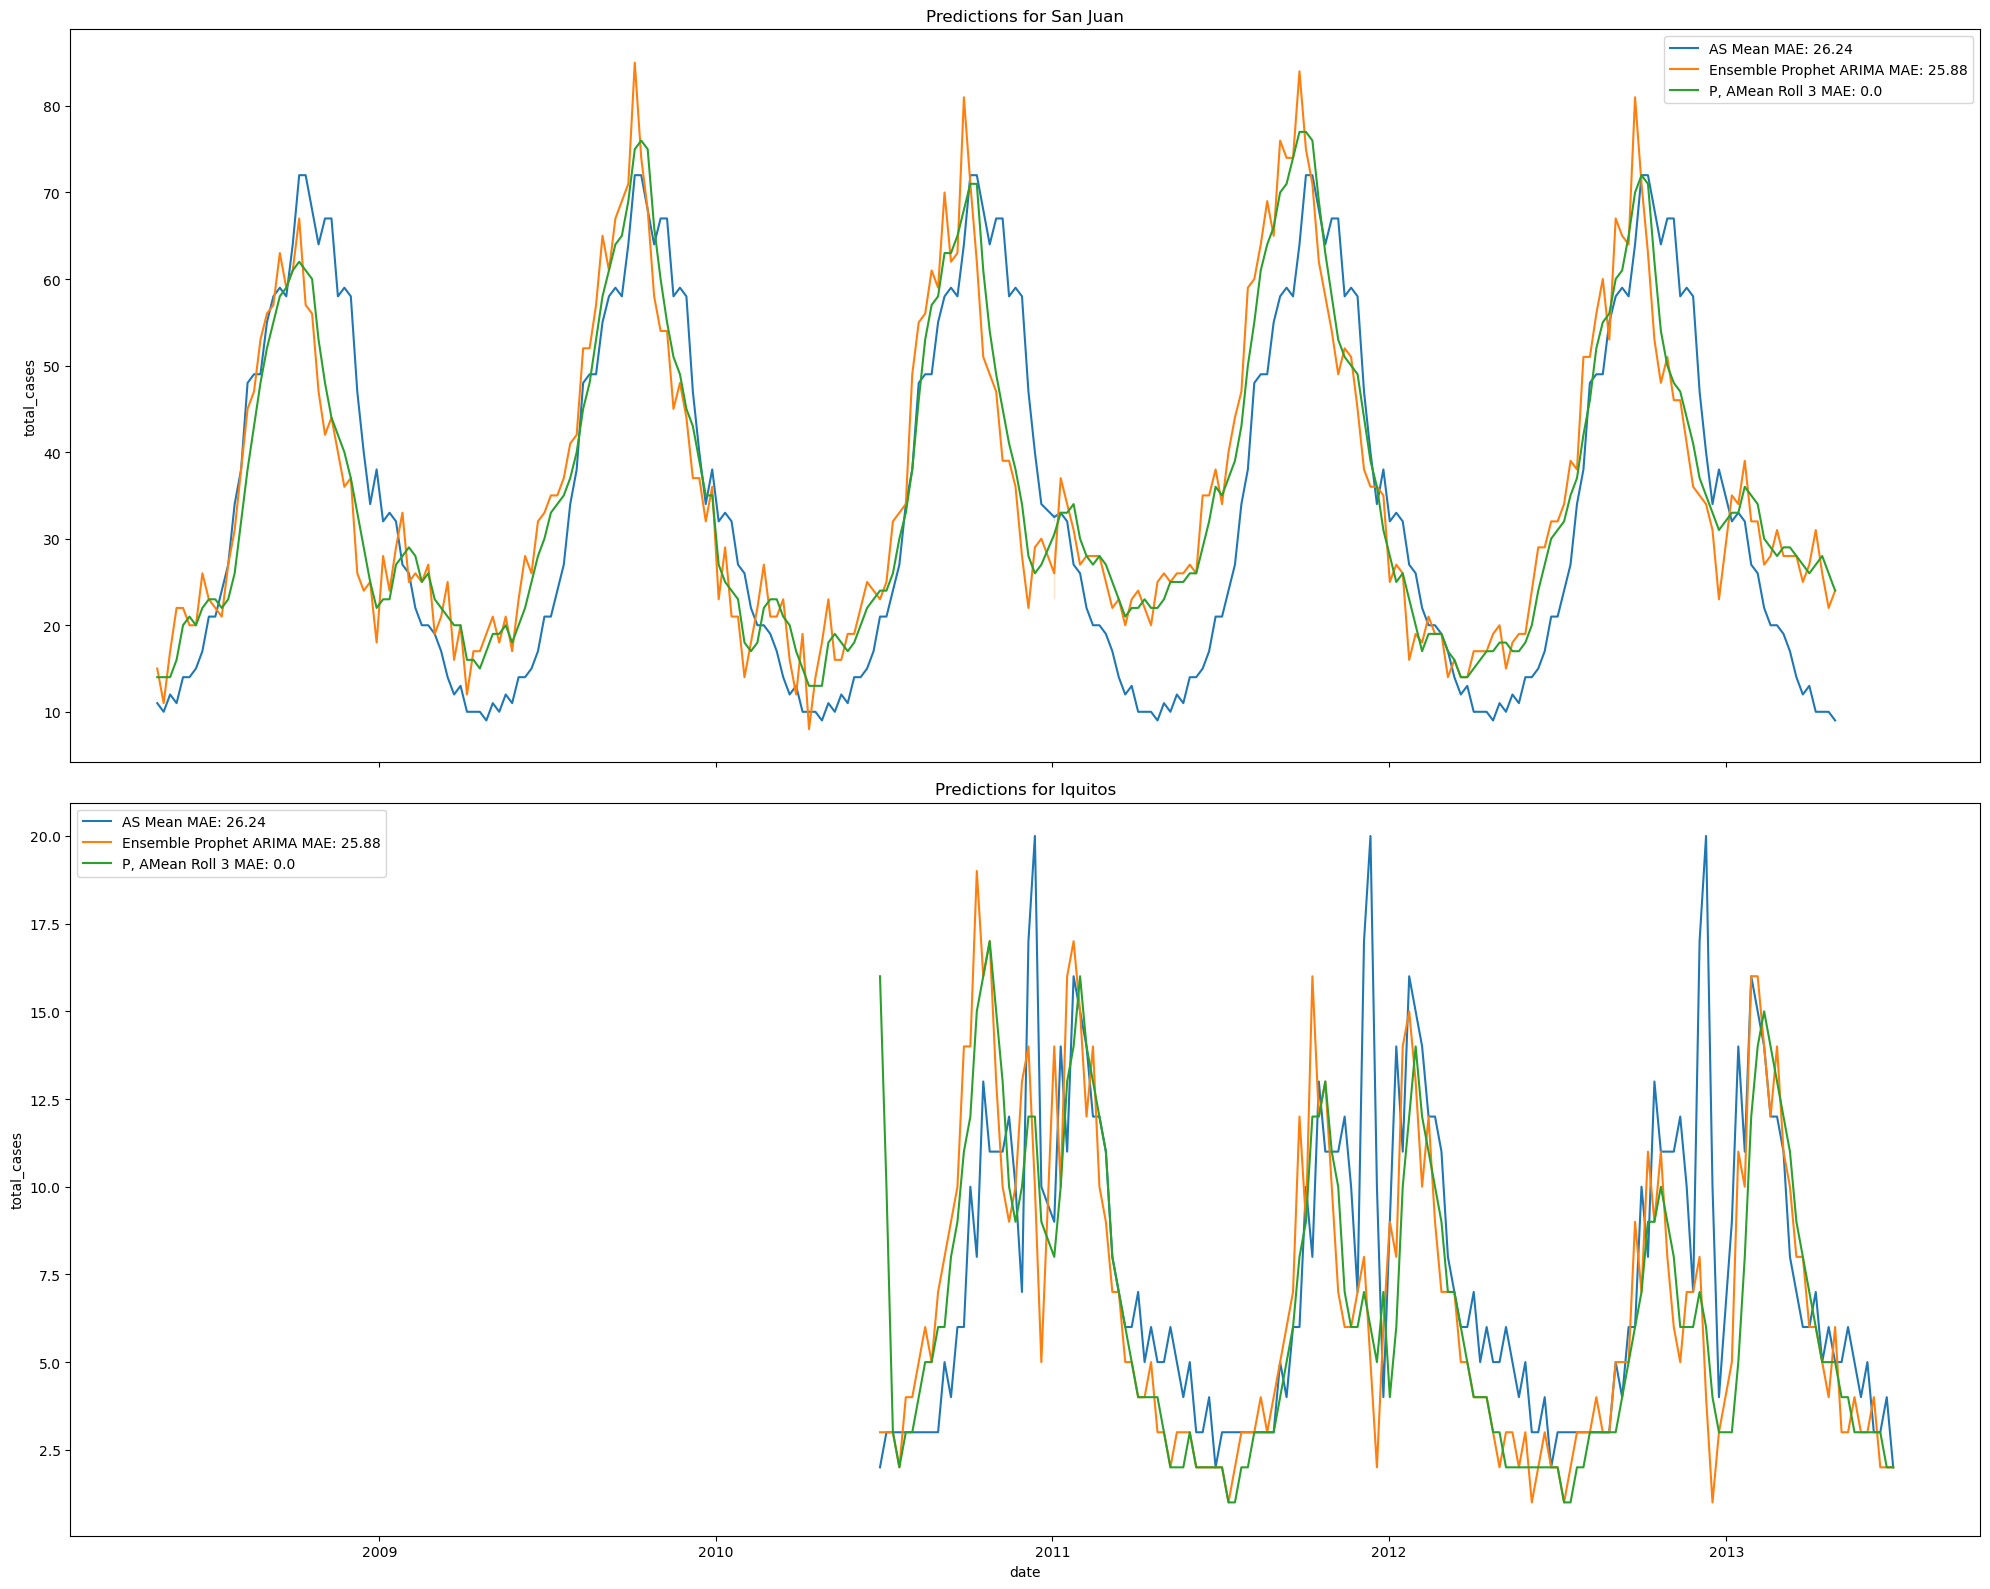

In [75]:
plot_predictions(
    # (prophet_mean, 27.10, 'Prophet Mean'),
    # (arima, 26.37, 'ARIMA'),
    # (prev_iter_rf, 26.75, 'Prev Iter RF'),
    (as_mean, 26.24, 'AS Mean'),
    (ensemble_prophet_arima, 25.88, 'Ensemble Prophet ARIMA'),
    # (maximum_df, 27.51, 'Maximum'),
    # (max_for_sj_mean_for_iq, 0.0, 'Max for SJ Mean for IQ'),
    (proph_arima_mean_roll_3, 0.0, 'P, AMean Roll 3'),
)

Below, there is code to existing ensebles

In [5]:
def weighted_average(predictions, weights):
    """
    Computes the weighted average of predictions.

    Parameters:
    predictions (list): List of prediction DataFrames.
    weights (list): List of weights for each prediction.

    Returns:
    pd.DataFrame: DataFrame containing the weighted average predictions.
    """
    
    weighted_sum = sum(weight * pred['total_cases'] for weight, pred in zip(weights, predictions))
    total_weight = sum(weights)
    
    res = weighted_sum / total_weight
    res = res.astype(int)
    submission_format = pd.read_csv('../data/submission_format.csv')
    
    submission_format['total_cases'] = res
    return submission_format

In [28]:
def maximum(predictions):
    """
    Computes the maximum of predictions.

    Parameters:
    predictions (list): List of prediction DataFrames.

    Returns:
    pd.DataFrame: DataFrame containing the maximum predictions.
    """
    
    max_pred = pd.concat(predictions, axis=0).groupby(['city', 'year', 'weekofyear'], as_index = False).max()
    submission_format = pd.read_csv('../data/submission_format.csv')
    submission_format = submission_format.merge(max_pred, on=['city', 'year', 'weekofyear'], how='left')
    submission_format['total_cases'] = submission_format['total_cases_y']
    submission_format = submission_format.drop(columns=['total_cases_x', 'total_cases_y', 'date'])
    return submission_format

In [21]:
arima

,city,year,weekofyear,total_cases
0,sj,2008,18,9
1,sj,2008,19,9
2,sj,2008,20,11
3,sj,2008,21,10
4,sj,2008,22,16
...,...,...,...,...
411,iq,2013,22,6
412,iq,2013,23,8
413,iq,2013,24,4
414,iq,2013,25,4


In [22]:
df_mean = weighted_average([prophet_mean, arima], [0.5, 0.5])
# df.to_csv('../data/predictions/ensemble/prophet_arima.csv', index=False)

In [29]:
df_maximum = maximum([prophet_mean, arima, as_mean])
df_maximum.to_csv('../data/predictions/ensemble/maximum.csv', index=False)

In [30]:
# maximum for SJ and mean for IQ
df_mean_max = pd.concat([df_maximum[df_maximum['city'] == 'sj'], df_mean[df_mean['city'] == 'iq']])
df_mean_max.to_csv('../data/predictions/ensemble/mean_for_iq_max_for_sj.csv', index=False)

In [37]:
df_mean

,city,year,weekofyear,total_cases
0,sj,2008,18,15
1,sj,2008,19,11
2,sj,2008,20,17
3,sj,2008,21,22
4,sj,2008,22,22
...,...,...,...,...
411,iq,2013,22,3
412,iq,2013,23,4
413,iq,2013,24,2
414,iq,2013,25,2


In [73]:
df_mean_roll = df_mean.copy()
df_mean_roll['total_cases'] = df_mean['total_cases'].rolling(3).mean()
df_mean_roll = df_mean_roll.interpolate(method="bfill")
df_mean_roll['total_cases'] = df_mean_roll['total_cases'].astype(int)
df_mean_roll
df_mean_roll.to_csv('../data/predictions/ensemble/proph_arima_mean_roll_3.csv', index=False)


/var/folders/3h/472d34x91dd8vpqfg3cg45qh0000gn/T/ipykernel_72726/1440173421.py:3: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_mean_roll = df_mean_roll.interpolate(method="bfill")
